# Linear regression with multiple variables

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
from matplotlib import style 
import theano
import theano.tensor as T

/Users/vitormeriat/anaconda/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
data = np.loadtxt('ex1data2.txt', delimiter=',')
m = len(data)
xt = np.ones((m, 3))
xt[:, (1, 2)] = data[:, (0, 1)] # 给x添加一列1'
labelt = np.zeros((m, 1))
labelt[:, 0] = data[:, 2]

In [5]:
# Transformação de escala de recurso
def featureNormalize(x): 
    mu = x.mean(0)
    #sigma = x.std(0) # Diferença de marca global estimada, dividida por m, matlab dividido por m - 1, desvio padrão estimado da amostra
    sigma = np.sqrt(((x - mu) ** 2).sum(0) / (len(x) - 1)) # Desvio padrão da amostra
    x_norm = (x - mu) / sigma
    return x_norm, mu, sigma

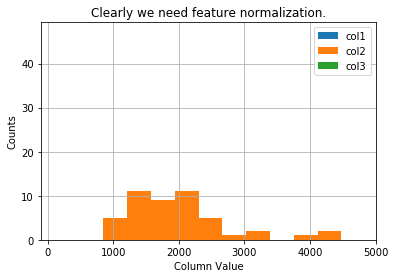

In [6]:
# Desenhe um histograma de dados

plt.grid(True)
plt.xlim([-100,5000])
dummy = plt.hist(xt[:,0],label = 'col1')
dummy = plt.hist(xt[:,1],label = 'col2')
dummy = plt.hist(xt[:,2],label = 'col3')
plt.title('Clearly we need feature normalization.')
plt.xlabel('Column Value')
plt.ylabel('Counts')
dummy = plt.legend()

In [7]:
# feature normalization
xt = np.ones((m, 3))
xt[:, (1, 2)], mu, sigma = featureNormalize(data[:, (0, 1)]) # Escale o recurso e adicione uma coluna 1

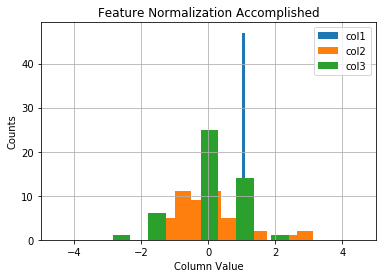

In [8]:
#Quick visualize the feature-normalized data
plt.grid(True)
plt.xlim([-5,5])
dummy = plt.hist(xt[:,0],label = 'col1')
dummy = plt.hist(xt[:,1],label = 'col2')
dummy = plt.hist(xt[:,2],label = 'col3')
plt.title('Feature Normalization Accomplished')
plt.xlabel('Column Value')
plt.ylabel('Counts')
dummy = plt.legend()

In [9]:
# Construa o modelo
x = T.matrix(name='x', dtype='float64') #  (47 3)
theta_np = np.zeros((3, 1), dtype='float64') 
label = T.matrix(name='label', dtype='float64') # (47 1)
alpha = T.scalar(name='alpha', dtype='float64')
theta = theano.shared(theta_np, name='theta') # (3, 1)

In [10]:
y = x.dot(theta) # (47 1)
predict = theano.function([x], y)
loss = T.mean((y - label) ** 2) / 2 # scalar
calcLoss = theano.function([x, label], loss)
grad_a = T.mean(y - label) # 手动公式求导, scalar
grad_b = T.mean((y - label) * (x[:, 1]).dimshuffle(0, 'x')) #  A forma de (rótulo-y) é (47,1), e a forma de x [:, 1] é (47,) Tudo o que precisa ser alterado usando dimshuffle (47,1)
grad_c = T.mean((y - label) * (x[:, 2]).dimshuffle(0, 'x')) 
gradient_step = theano.function([x, label, alpha],updates={theta : theta - alpha * T.stack([[grad_a], [grad_b], [grad_c]])}) # Precisa dessa pilha, ou .dimshuffle (0, 'x')

In [11]:
grad_all =  T.mean((y - label).repeat(3, 1) * x, axis=0)  # Outra derivação manual, solicitação única para três variáveis
gradient_step_all = theano.function([x, label, alpha],updates={theta : theta - alpha * grad_all.dimshuffle(0, 'x')})

In [12]:
grad = T.grad(loss, theta) # Derivação automática
gradient_step_auto = theano.function([x, label, alpha],updates={theta : theta - alpha * grad}) # gradient_step_auto derivado automaticamente

In [13]:
calcLoss(xt,labelt)

array(65591548106.45744)

In [14]:
# Modelo de treinamento em gradiente descendente

# Treinamento direto
theta.set_value(theta_np)
num_iters = 8500
J_history = np.zeros((num_iters, 1))
for i in range(num_iters):
    gradient_step(xt, labelt, 0.01)
    J_history[i] = calcLoss(xt, labelt)
thetaResult = theta.get_value()
print(thetaResult) 

[[ 340412.65957447]
 [ 110631.05027884]
 [  -6649.47427082]]


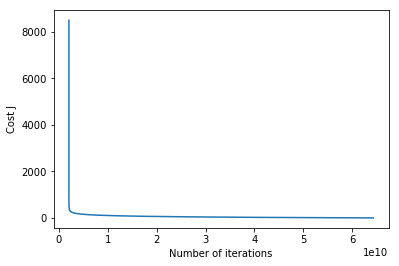

In [15]:
# Plot the convergence graph

fig = plt.figure() 
plt.plot(J_history, np.arange(num_iters) + 1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

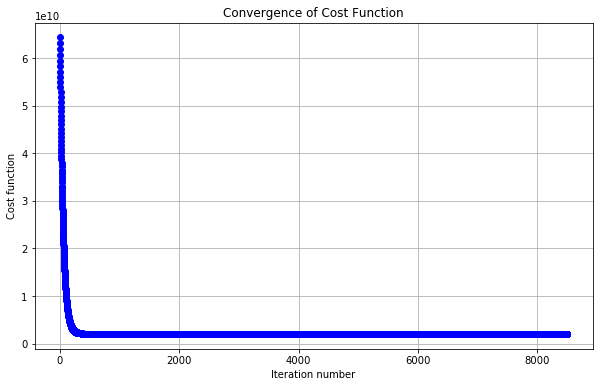

In [16]:
# Outra maneira de desenhar gráficos de convergência

#Plot the convergence of the cost function
def plotConvergence(jvec):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(jvec)),jvec,'bo')
    plt.grid(True)
    plt.title("Convergence of Cost Function")
    plt.xlabel("Iteration number")
    plt.ylabel("Cost function")
    dummy = plt.xlim([-0.05*num_iters,1.05*num_iters])
    #dummy = plt.ylim([4,8])
    
plotConvergence(J_history)

In [19]:
# Prever uma nova amostra

def predict(ytest, theta):
    ytest = np.array(ytest)
    ytestscaled = [(ytest[x]-mu[x])/sigma[x] for x in range(len(ytest))] # feature normalization,
    ytestscaled.insert(0,1)
    return float(np.array([ytestscaled]).dot(theta))

In [20]:
#print "Final result theta parameters: \n",theta
print("Check of result: What is price of house with 1650 square feet and 3 bedrooms?") 
ytest = np.array([1650.,3.])
print("$%0.2f" % predict(ytest, theta.get_value())) 

Check of result: What is price of house with 1650 square feet and 3 bedrooms?
$293081.46


### Resolução de equações normais

$\theta = \left( X^T X \right)^{-1} X^T y $

In [22]:
from numpy.linalg import inv
#Implementation of normal equation to find analytic solution to linear regression
def normEqtn(X,y):
    #restheta = np.zeros((X.shape[1],1))
    return np.dot(np.dot(inv(np.dot(X.T,X)),X.T),y)